## Imports

In [1]:
import cv2 as cv
import json
import matplotlib.pyplot as plt
import torch
import glob

from torchvision.transforms import v2

## Checking Annotations

In [2]:
# Read a JSON file
with open('data/Annotations/train.json') as f:
    trainJSON = json.load(f)

with open('data/Annotations/dev.json') as f:
    valJSON = json.load(f)

with open('data/Annotations/test.json') as f:
    testJSON = json.load(f)

In [3]:
classes = trainJSON['categories']

train_images = trainJSON['images']
val_images = valJSON['images']
test_images = testJSON['images']

train_annotations = trainJSON['annotations']
val_annotations = valJSON['annotations']
test_annotations = testJSON['annotations']

In [4]:
print('========= Classes =========')
display(classes)
print('========= Train images =========')
display(train_images[:2])
print('========= Train nnotations =========')
display(train_annotations[:2])

========= Classes =========


[{'id': 1, 'name': 'LE;ER', 'supercategory': None},
 {'id': 4, 'name': 'SF;PO', 'supercategory': None},
 {'id': 0, 'name': 'VG;MT', 'supercategory': None},
 {'id': 2, 'name': 'LR;DA', 'supercategory': None},
 {'id': 3, 'name': 'LE;CR', 'supercategory': None}]

========= Train images =========


[{'id': 0,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0058_1_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3},
 {'id': 1,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0013_0_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3}]

========= Train nnotations =========


[{'image_id': 0,
  'id': 0,
  'segmented': None,
  'bbox': [383.996928, 424.001024, 99.00032, 90.000384],
  'area': 8910.0668161229,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 1,
  'difficult': None},
 {'image_id': 0,
  'id': 1,
  'segmented': None,
  'bbox': [616.001024, 20.00128, 45.999104, 47.000576],
  'area': 2161.9843834839,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 4,
  'difficult': None}]

In [5]:
train_images_names = []
val_images_names = []
test_images_names = []

for metadata in train_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    train_images_names.append(img_name)

for metadata in val_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    val_images_names.append(img_name)

for metadata in test_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    test_images_names.append(img_name)

# Drop duplicates from the lists
train_images_names = list(set(train_images_names))
val_images_names = list(set(val_images_names))
test_images_names = list(set(test_images_names))

In [6]:
print('========= Train images names =========')
display(train_images_names[:11])
print('========= Validation images names =========')
display(val_images_names[:11])
print('========= Test images names =========')
display(test_images_names[:11])

========= Train images names =========


['DJI_0705.JPG',
 'DJI_0161.JPG',
 'DJI_0014.JPG',
 'DJI_0196.JPG',
 'DJI_0212.JPG',
 'DJI_0753.JPG',
 'DJI_0051.JPG',
 'DJI_0758.JPG',
 'DJI_0713.JPG',
 'DJI_0409.JPG',
 'DJI_0118.JPG']

========= Validation images names =========


['DJI_0110.JPG',
 'DJI_0248.JPG',
 'DJI_0033.JPG',
 'DJI_0712.JPG',
 'DJI_0117.JPG',
 'DJI_0627.JPG',
 'DJI_0711.JPG',
 'DJI_0115.JPG',
 'DJI_0708.JPG',
 'DJI_0695.JPG',
 'DJI_0048.JPG']

========= Test images names =========


['DJI_0038.JPG',
 'DJI_0055.JPG',
 'DJI_0203.JPG',
 'DJI_0091.JPG',
 'DJI_0180.JPG',
 'DJI_0413.JPG',
 'DJI_0201.JPG',
 'DJI_0053.JPG',
 'DJI_0710.JPG',
 'DJI_0694.JPG',
 'DJI_0747.JPG']

## Data Augmentation

In [7]:
# Create a class that creates a PyTorch dataset for all images in data/Nordtank 2017
class NordtankDataset(torch.utils.data.Dataset):
    def __init__(self, images_names, transform=None):
        self.images_names = images_names
        self.transform = transform

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        img_name = self.images_names[idx]
        img_path = img_name
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = torch.from_numpy(image.transpose(2, 0, 1))

        if self.transform:
            image = self.transform(image)
            image = image.permute(1, 2, 0)

        return image
    

# Create a class that creates a PyTorch dataset for all images in data/Nordtank 2017 without any transformations
class NordtankDatasetNoTransform(torch.utils.data.Dataset):
    def __init__(self, images_names):
        self.images_names = images_names

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        img_name = self.images_names[idx]
        img_path = img_name
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = torch.from_numpy(image.transpose(2, 0, 1))
        image = image.permute(1, 2, 0)

        return image
    

def BeforeAfterDataAugmentation(aug_dataset, originals_dataset, idx):

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(originals_dataset[idx])
    axes[0].set_title('Before data augmentation')
    axes[1].imshow(aug_dataset[idx])
    axes[1].set_title('After data augmentation')

In [8]:
images_2017 = glob.glob('data/Nordtank 2017/*.JPG')

# Define the transformation pipeline
transform = v2.Compose([
                        v2.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                        v2.RandomVerticalFlip(),    # Randomly flip the image vertically
                        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue
                        v2.ToTensor(),               # Convert the image to a PyTorch tensor
                        ])

/Users/luish/anaconda3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
DataAugmentationDataset = NordtankDataset(images_2017, transform = transform)
OriginalDataset = NordtankDatasetNoTransform(images_2017)
Dataset = torch.utils.data.ConcatDataset([OriginalDataset, DataAugmentationDataset])

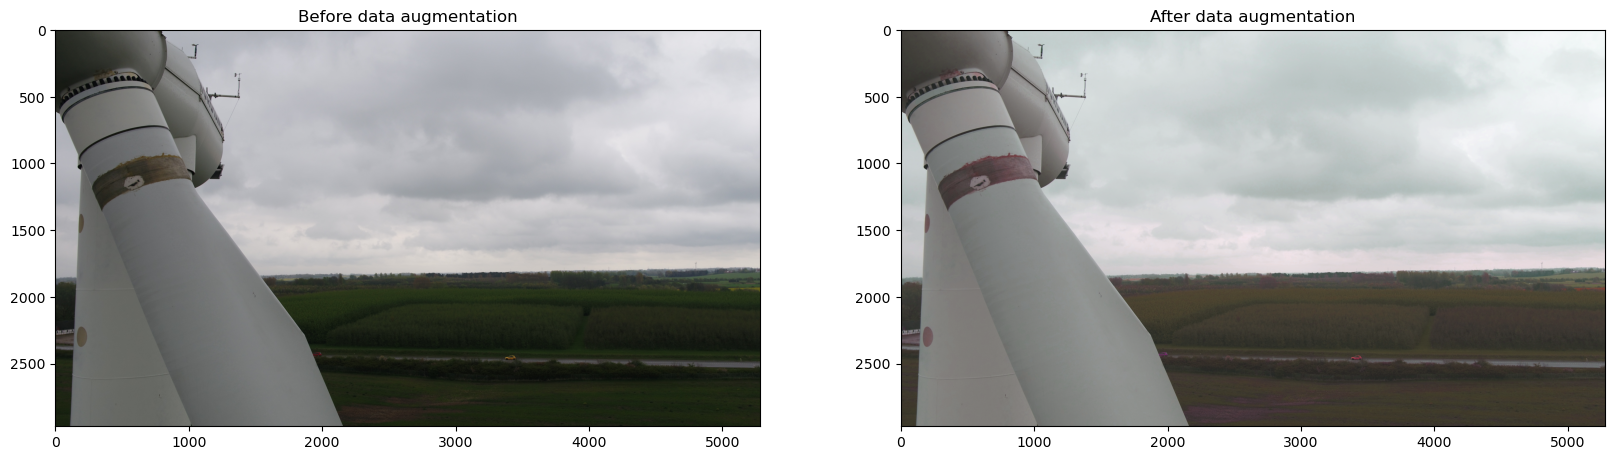

In [10]:
BeforeAfterDataAugmentation(DataAugmentationDataset, OriginalDataset, 0)

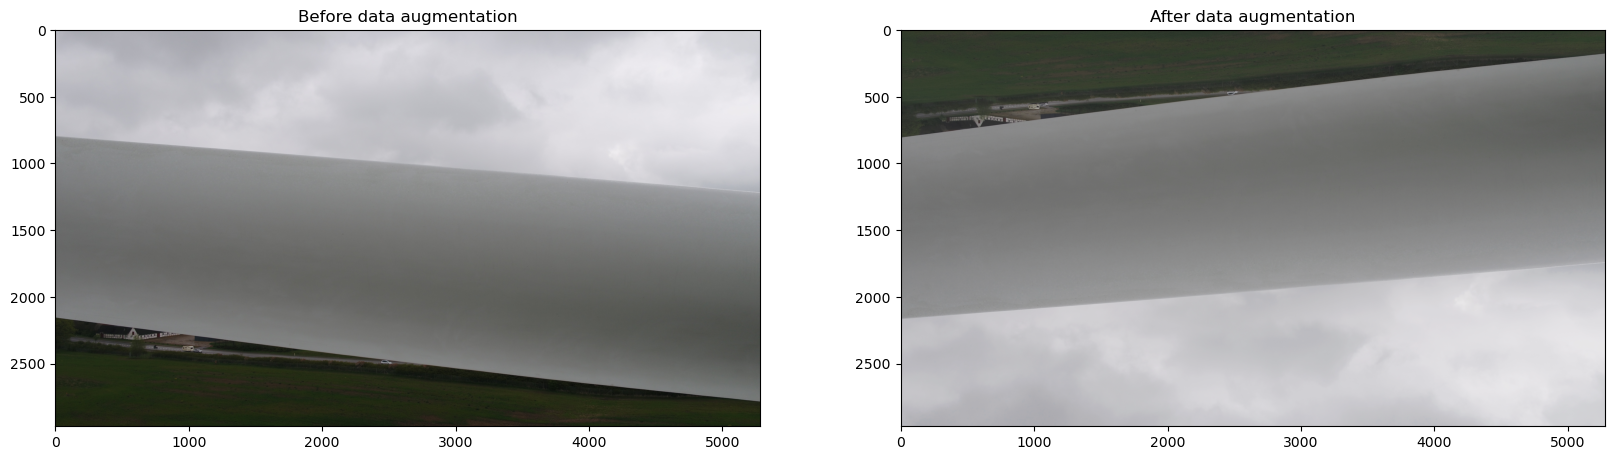

In [11]:
BeforeAfterDataAugmentation(DataAugmentationDataset, OriginalDataset, 50)

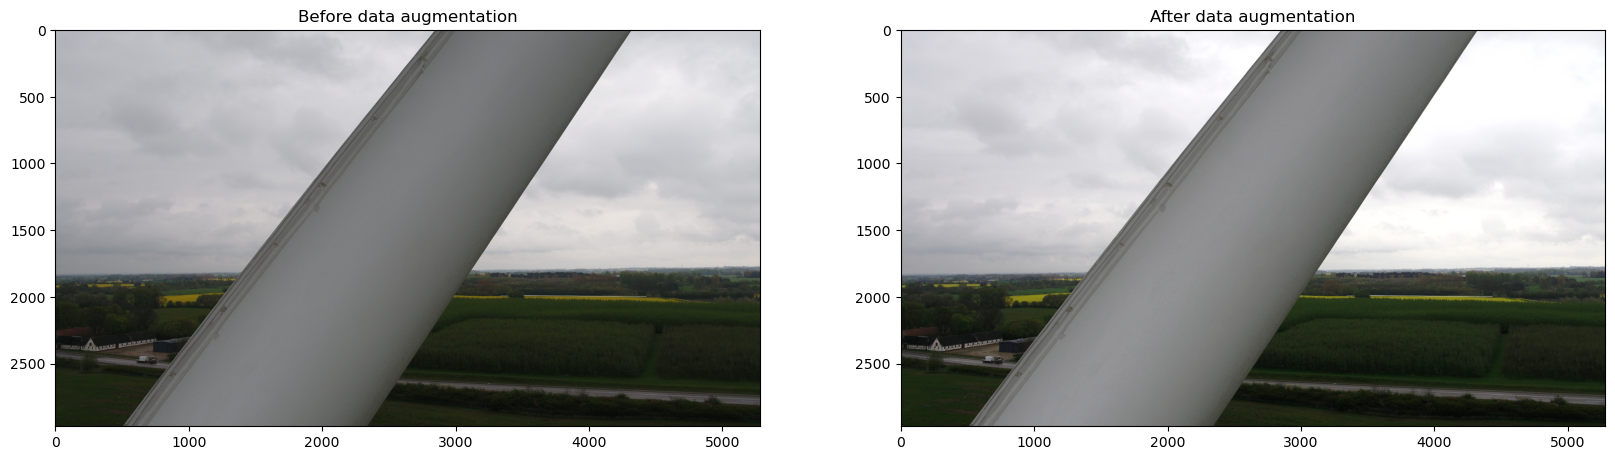

In [12]:
BeforeAfterDataAugmentation(DataAugmentationDataset, OriginalDataset, 100)

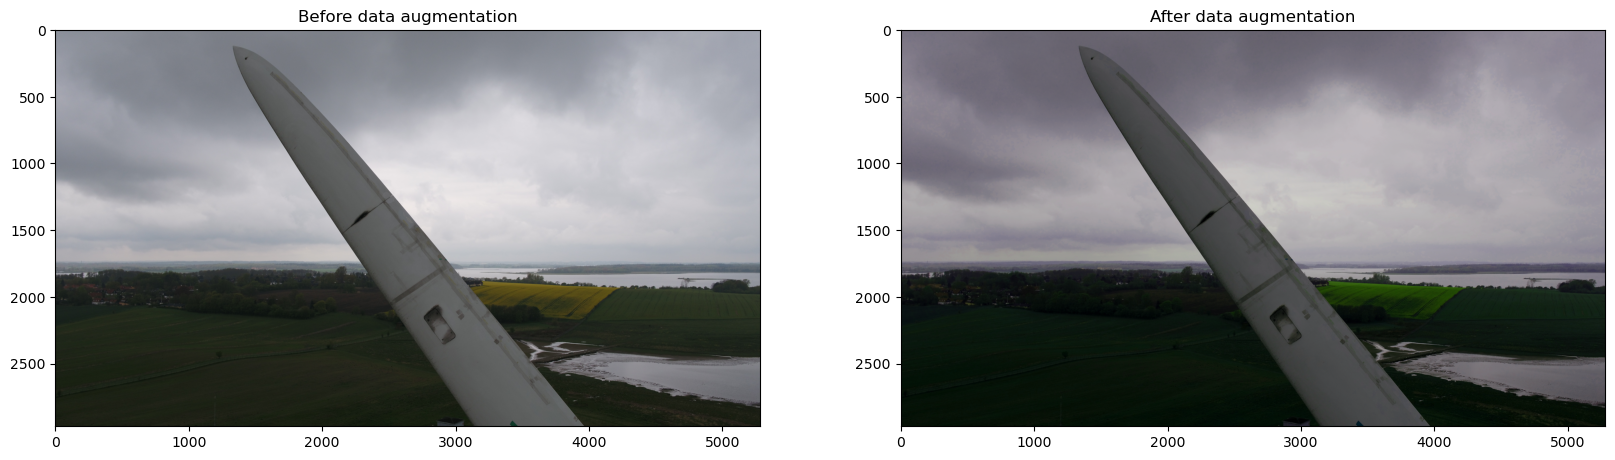

In [13]:
BeforeAfterDataAugmentation(DataAugmentationDataset, OriginalDataset, 150)

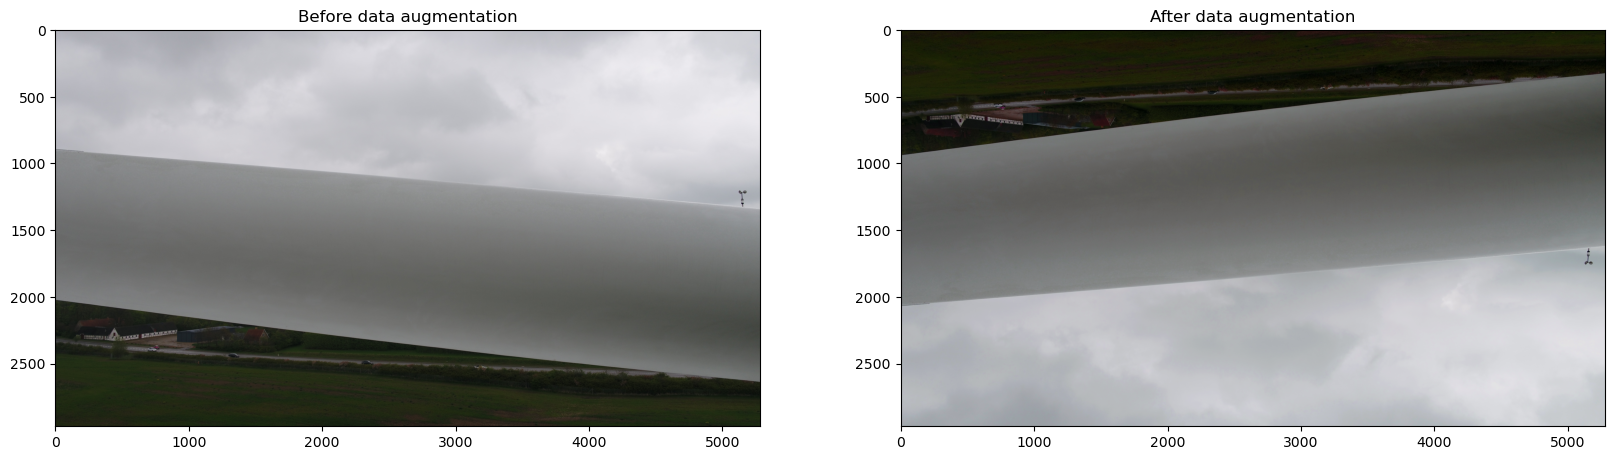

In [15]:
BeforeAfterDataAugmentation(DataAugmentationDataset, OriginalDataset, 160)